In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

In [2]:
def visualize_graph(G):
    pos = nx.spring_layout(G)  # You can use other layouts as well

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='black', width=1.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)

    # Draw node labels
    node_labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    plt.title("Graph Visualization")
    plt.show()

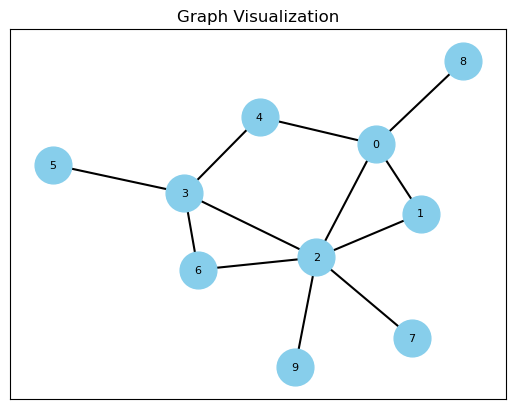

In [11]:
G = nx.scale_free_graph(n=10,alpha=.41).to_undirected()
G.remove_edges_from(list(nx.selfloop_edges(G)))
visualize_graph(G)